<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020/blob/main/CNN_with_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified version of:
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb 



### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. The state of the art accuracy is 96.53 percent.


In [ ]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

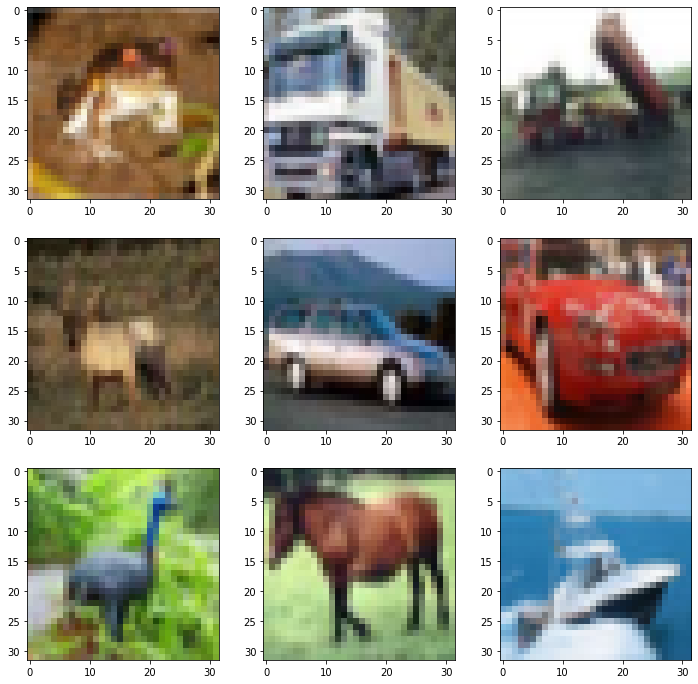

In [ ]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3

# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

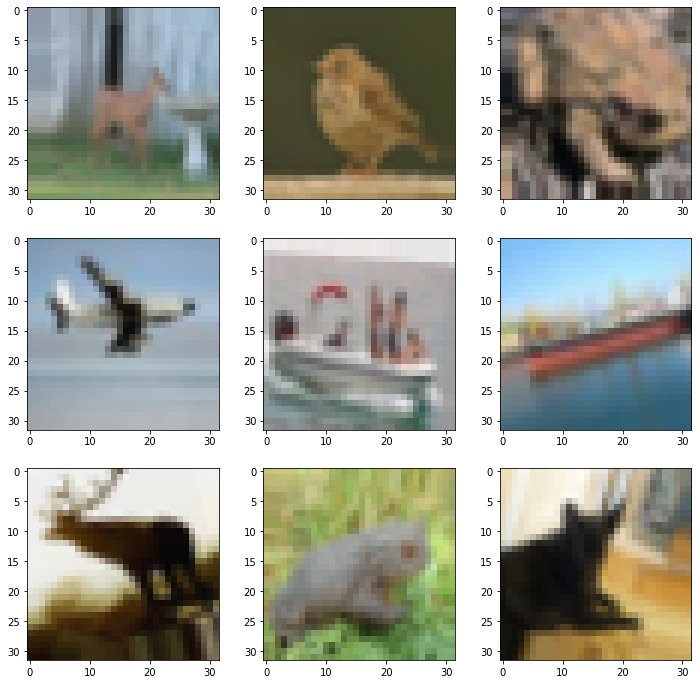

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

   

Augmentation of a single image

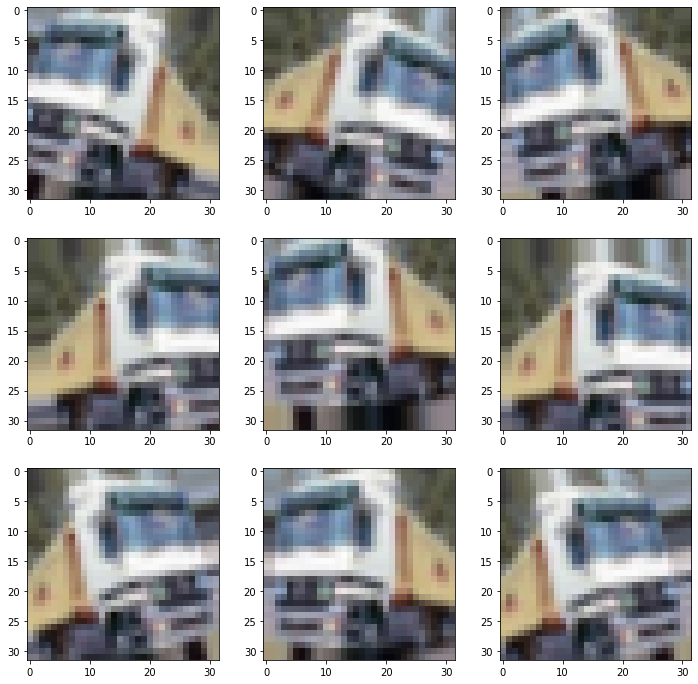

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 9):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[0].astype(np.uint8))
         break

plt.show()
    


In [ ]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [ ]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [ ]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 6s 16ms/step - loss: 1.5074 - accuracy: 0.5009 - val_loss: 1.2246 - val_accuracy: 0.5761
Epoch 2/100
391/391 [==============================] - 6s 15ms/step - loss: 0.8871 - accuracy: 0.6880 - val_loss: 0.7916 - val_accuracy: 0.7247
Epoch 3/100
391/391 [==============================] - 6s 16ms/step - loss: 0.6940 - accuracy: 0.7575 - val_loss: 0.7167 - val_accuracy: 0.7504
Epoch 4/100
391/391 [==============================] - 6s 16ms/step - loss: 0.5781 - accuracy: 0.7982 - val_loss: 0.7158 - val_accuracy: 0.7541
Epoch 5/100
391/391 [==============================] - 6s 16ms/step - loss: 0.4868 - accuracy: 0.8305 - val_loss: 0.6425 - val_accuracy: 0.7865
Epoch 6/100
391/391 [==============================] - 6s 16ms/step - loss: 0.4092 - accuracy: 0.8568 - val_loss: 0.6444 - val_accuracy: 0.7884
Epoch 7/100
391/391 [==============================] - 6s 16ms/step - loss: 0.3380 - accuracy: 0.8828 - val_loss: 0.8341 - val_accuracy:

In [ ]:
#training accuracy without dropout
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc

391/391 [==============================] - 2s 5ms/step - loss: 0.0084 - accuracy: 0.9970


[0.008381578139960766, 0.9970399737358093]

In [ ]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

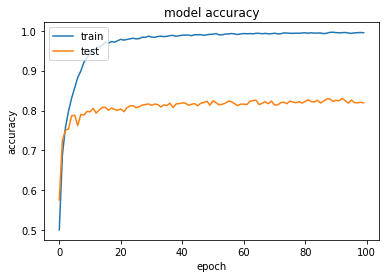

In [ ]:
plothist(history)

In [ ]:
#model.save('cifar10_01.h5')                  
#model=load_model('cifar10_01.h5')

In [ ]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Flatten())
model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
# train with image augmentation
history2=model2.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/390 [==============================] - 24s 62ms/step - loss: 1.6399 - accuracy: 0.4576 - val_loss: 1.1456 - val_accuracy: 0.5900
Epoch 2/100
391/390 [==============================] - 24s 62ms/step - loss: 1.0752 - accuracy: 0.6194 - val_loss: 1.1185 - val_accuracy: 0.6263
Epoch 3/100
391/390 [==============================] - 24s 61ms/step - loss: 0.8863 - accuracy: 0.6870 - val_loss: 0.8206 - val_accuracy: 0.7172
Epoch 4/100
391/390 [==============================] - 24s 61ms/step - loss: 0.7829 - accuracy: 0.7262 - val_loss: 0.7688 - val_accuracy: 0.7410
Epoch 5/100
391/390 [==============================] - 24s 61ms/step - loss: 0.7057 - accuracy: 0.7547 - val_loss: 0.6940 - val_accuracy: 0.7647
Epoch 6/100
391/390 [==============================] - 24s 61ms/step - loss: 0.6511 - accuracy: 0.7741 - val_loss: 0.7218 - val_accuracy: 0.7556
Epoch 7/100
391/390 [==============================] - 24s 62ms/step - loss: 0.6132 - accuracy: 0.7888 - val_loss: 0.7670 - val_ac

In [ ]:
#model2.save('cifar10_02.h5')         # about 90% accuracy

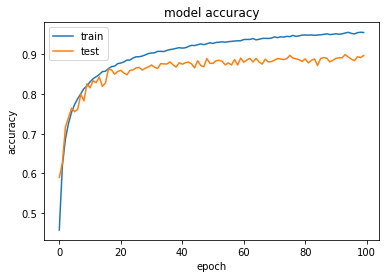

In [ ]:
plothist(history2)  # 128 batch, 0.001 lr, 

In [ ]:
model2_test_acc=model2.evaluate(x_test,y_test,batch_size=128)
model2_test_acc

79/79 [==============================] - 0s 5ms/step - loss: 0.3804 - accuracy: 0.8974


[0.38040944933891296, 0.8974000215530396]

In [ ]:
model2_train_acc=model2.evaluate(x_train,y_train,batch_size=128)
model2_train_acc

391/391 [==============================] - 2s 5ms/step - loss: 0.0605 - accuracy: 0.9793


[0.06046811491250992, 0.9793000221252441]

# **Plot images**

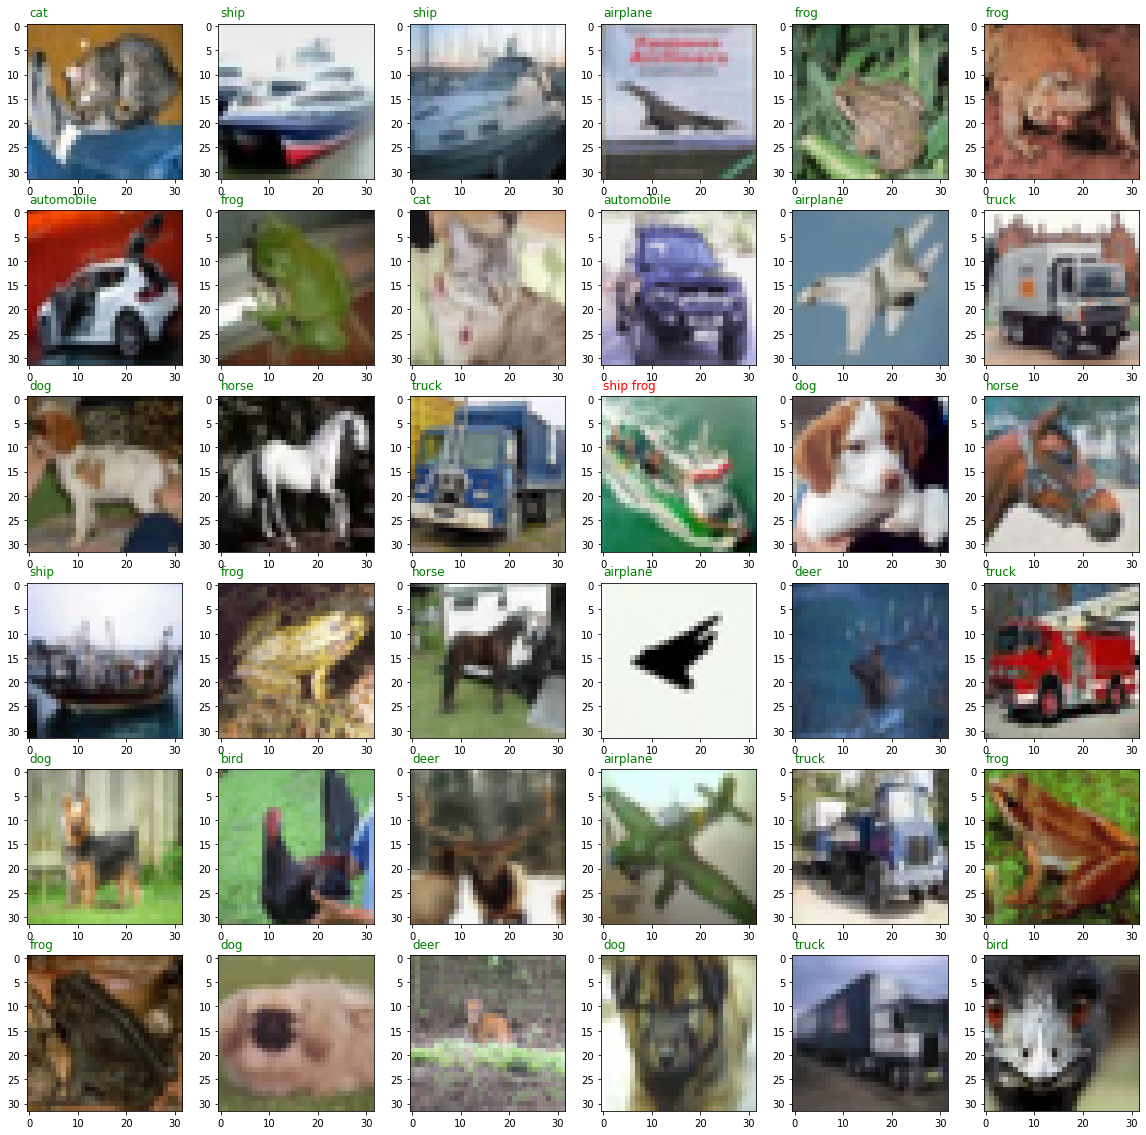

In [ ]:
# Names of predicted classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

y_pred = model2.predict_classes(x_test)

fig = plt.figure(figsize=(20, 20))
for i in range(0,36):
    plt.subplot(6,6,i+1)
    plt.imshow(xx_test[i])
    if yy_test[i] == y_pred[i]:
      plt.text(0, -2, class_names[int(yy_test[i])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i])]+" "+class_names[y_pred[i]], color='red', fontsize=12)  
plt.show()